# Simple Python example: shear frame

In [60]:
import koma.oma, koma.plot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import detrend, welch, resample

from knutils.modal import statespace as to_A
from knutils.structural import shearframe
from beef.newmark import newmark_lin

import pandas as pd


## System definition

In [116]:
k = 8000
m = 500
c = 10
levels = 3
fs = 3.0
tmax = 3600

K, C, M, __ = shearframe(levels, k, c, m, relative_dampers=False)

t_sim = np.arange(0, tmax, 1/fs_sim)

u0 = np.zeros([levels])
udot0 = u0*1

f = np.random.randn(levels, len(t_sim))*10000
u, __, __ = newmark_lin(K, C, M, f, t_sim, u0, udot0)

## Analytical eigenvalue solution

In [117]:
A = to_A(K, C, M) # establish state matrix based on K, C and M
lambdai, qi = np.linalg.eig(A)

ix = np.argsort(np.abs(lambdai))
xi = -np.real(lambdai)/np.abs(lambdai)
print(np.sort(np.abs(lambdai[::2])/np.pi/2))

[0.28332245 0.79385187 1.14714919]


## Define SSI parameters


In [122]:
i = 30
s = 4

orders = np.arange(2, 60+2, 2)
stabcrit = {'freq':0.2, 'damping': 0.2, 'mac': 0.3}

## Add artificial noise and plot response

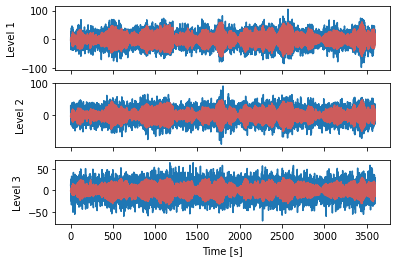

In [124]:
noise_factor = 1.0

noise = np.std(data) * noise_factor
data_noised = data + noise*np.random.randn(data.shape[0], data.shape[1])

fig, ax = plt.subplots(nrows=levels, ncols=1, num=1, sharex =True)

for level, axi in enumerate(ax):    
    axi.plot(t, data_noised[:,level])
    axi.plot(t, data[:,level], color='IndianRed', alpha=1)
    axi.set_ylabel(f'Level {level+1}')

__ = ax[-1].set_xlabel('Time [s]')


## Cov-SSI call

In [125]:
lambd, phi = koma.oma.covssi(data_noised, fs, i, orders) # find poles by Cov-SSI
lambd_stab, phi_stab, orders_stab, ix_stab = koma.oma.find_stable_poles(lambd, phi, orders, s, stabcrit=stabcrit, indicator='mac') # Stable poles

*** Covariance-driven SSI algorithm for OMA ***
> Establishing Hankel/Toeplitz matrices
  >> Correlation estimation
  >> Matrix stacking
> Establishing weighting matrices
  >> Weighting requested: NONE
> Computing SVD
> Computing state matrix for each order to establish modes
> Computation completed


## Welch PSD estimate

In [126]:
nperseg = 1024
zp = 4
nfft = nperseg*zp

f, Pxx = welch(data_noised[:,0], fs, 'hanning', nperseg=nperseg, nfft=nfft)

## Visualization: stabilization plot

In [1]:
fig = koma.plot.stabplot(lambd_stab, orders_stab, renderer='notebook', psd_freq=f, psd_y=Pxx, 
                         frequency_unit='hz', freq_range=[0,1.5], damped_freq=False)

NameError: name 'koma' is not defined

As seen, the analytical critical damping ratios are 0.5617449% (mode 1), 0.20048443% (mode 2), and 0.13873953% (mode 3). The stabilization plot shows experimental data with reasonable agreement!

If you want to be able to use interactive selection of poles (append to table)- uses the following syntax in your IPython environment:

	
`fig = koma.plot.stabplot(lambd_stab, orders_stab, renderer=None, psd_freq=f, psd_y=Pxx, 
    frequency_unit='Hz', freq_range=[0,1.5], to_clipboard='ix', damped_freq=False)`
    
`fig`

This generates the following interactive interface:
![title](stabplot_interactive.png)

(This is not used above because it does not export well for static online docs)

# Pole clustering
By using pole clustering tecniques available in the `clustering` module, you can obtain modal results without any manual selection. The module is based on the HDBSCAN method, and relies on the `hdbscan` python package. The two cells below show how the module is used to automatically identify estimates of the three modes of ours system.

In [134]:
import koma.clustering

pole_clusterer = koma.clustering.PoleClusterer(lambd_stab, phi_stab, orders_stab, min_cluster_size=10, min_samples=10, scaling={'mac':1.0, 'lambda_real':1.0, 'lambda_imag': 1.0})
prob_threshold = 0.5   #probability of pole to belong to cluster, based on estimated "probability" density function
args = pole_clusterer.postprocess(prob_threshold=prob_threshold, normalize_and_maxreal=True)

xi_auto, omega_n_auto, phi_auto, order_auto, probs_auto, ixs_auto = koma.clustering.group_clusters(*args)
xi_mean = np.array([np.mean(xi_i) for xi_i in xi_auto])
fn_mean = np.array([np.mean(om_i) for om_i in omega_n_auto])/2/np.pi

xi_std = np.array([np.std(xi_i) for xi_i in xi_auto])
fn_std = np.array([np.std(om_i) for om_i in omega_n_auto])/2/np.pi


In [143]:
# Print table
import pandas as pd
res_data = np.vstack([fn_mean, 100*xi_mean]).T
results = pd.DataFrame(res_data, columns=['$f_n$ [Hz]', r'$\xi$ [%]'])
results

,$f_n$ [Hz],$\xi$ [%]
0,0.28,0.53
1,0.75,0.18
2,1.03,0.15


As seen this matches the true eigenvalues very closely:


| $f_n$ [Hz] | $\xi$[%] |
|------------|------------
| 0.28       | 0.56      |
| 0.79       |     0.20  |
| 1.15       | 0.14       |


In [136]:
# Group only a selected quantity (e.g. indices)
lambd_used, phi_used, order_stab_used, group_ixs, all_single_ix, probs = pole_clusterer.postprocess(prob_threshold=prob_threshold)
grouped_ixs = koma.clustering.group_array(all_single_ix, group_ixs)       # for instance the indices only,
grouped_phis = koma.clustering.group_array(phi_used, group_ixs, axis=1)   # or the phis only


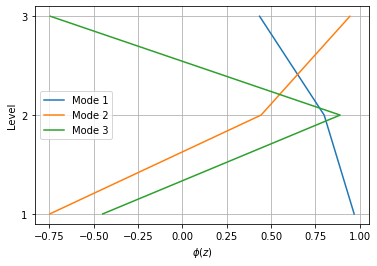

In [142]:
# Mode shapes
for mode,phis in enumerate(grouped_phis):
    plt.plot(np.real(np.mean(phis, axis=1)), np.arange(3)+1, label=f'Mode {mode+1}')
    
plt.xlabel('$\phi(z)$')
plt.ylabel('Level')
plt.yticks(np.arange(3)+1)
plt.grid('on')
plt.legend()